# <font color='#badc58'> Fake News Detector with LSTM |<br> </font>  
# <font color='#3dc1d3'>  
1.  Preprocess data
2.  one_hot encoding
3.  create LSTM model
4.  observe the alteration in shape, flattening and then re-shaping - changes from embedding to flattening - to - dense layer <br>
5. Observe the total weight matrix size of the LSTM - mathematical verification

## <font color='#f9ca24'> LSTM 
 <font color='00BFEB'>'fit' or train on some training data; joins these two steps and is used for the initial fitting of parameters on the training set 𝑥, while also returning the transformed 𝑥′. Internally, the transformer object just calls first fit() and then transform() on the same data.<br>In the output, you will see (20000, 5) which means that each of the document has 5 columns where each column corresponds to the probability value of a particular topic. 

In [1]:
import re
import pandas as pd
import nltk
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout 
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from sklearn.metrics import classification_report 
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [2]:
from google.colab import files
upload = files.upload()

Saving fakenews.zip to fakenews.zip


In [3]:
!unzip fakenews

Archive:  fakenews.zip
  inflating: train.csv               


In [5]:
df = pd.read_csv('train.csv')
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


### <font color='#badc58'>Let's take a look at the dataset.</font>  <br/> 
---


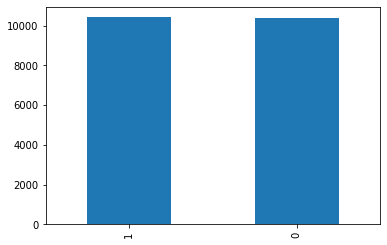

In [16]:
df['label'].value_counts().plot(kind='bar')

In [17]:
df['title'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

In [18]:
df['text'][0] #fake

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing emai

In [19]:
df.shape

(20800, 5)

In [20]:
df.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

<font color='#badc58'>drop missing data</font>  <br/> 

In [21]:
# drop only specific 2 columns
df = df.dropna(subset=['title', 'text'])

In [22]:
df.isna().sum()

id           0
title        0
author    1918
text         0
label        0
dtype: int64

In [23]:
df.shape

(20203, 5)

<font color='#badc58'>Preparing to create the model


In [24]:
x = df.drop(columns='label')
y = df['label']

In [25]:
x.shape, y.shape

((20203, 4), (20203,))

<font color='#7ed6df'>Data Preprocessing

In [27]:
copy = x.copy()
# copy the reference of nested objects
copy.reset_index(inplace=True)
copy = copy.drop(columns='id')
copy.head()

,index,title,author,text
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ..."
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...


In [33]:
ws = WordNetLemmatizer()
list_titles = []
for i in range(0, len(copy)):
  #print(i) # print copy['title' - i]
  headline = re.sub('[^a-zA-Z]', ' ', copy['title'][i])
  headline = headline.lower()
  headline = headline.split()
  headline = [ws.lemmatize(word) for word in headline if word not in stopwords.words('english')]
  headline = ' '.join(headline)
  list_titles.append(headline)

In [42]:
ws = WordNetLemmatizer()
for i in range(0, len(copy)):
  #print(i) # print copy['title' - i]
  headline = re.sub('[^a-zA-Z]', ' ', copy['title'][i])
  headline = headline.lower()
  headline = headline.split()
  headline = [ws.lemmatize(word) for word in headline if word not in stopwords.words('english')]
  headline = ' '.join(headline)
  copy['new_text'][i] =  headline #just try to create new columns, we will still use list_titles

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [43]:
copy.head()

,index,title,author,text,new_text
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,house dem aide even see comey letter jason cha...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,flynn hillary clinton big woman campus breitbart
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",truth might get fired
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,civilian killed single u airstrike identified
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,iranian woman jailed fictional unpublished sto...


In [41]:
list_titles[:5]

['house dem aide even see comey letter jason chaffetz tweeted',
 'flynn hillary clinton big woman campus breitbart',
 'truth might get fired',
 'civilian killed single u airstrike identified',
 'iranian woman jailed fictional unpublished story woman stoned death adultery']

<font color='#f9ca24'>Keras<font color='#7ed6df'> provide the function <font color='#f9ca24'>one_hot</font> to efficiently encode each word in the titles as an interger.<br>This must be done prior to Word Embedding<br><font color='#7ed6df'>Index of words located in the Dictionary

In [ ]:
vocab = 10000
hot_title = [one_hot(i, vocab) for i in list_titles]
hot_title[:4]

[[4692, 8653, 957, 6387, 1371, 3003, 4402, 3266, 5675, 973],
 [7896, 3966, 2918, 3686, 3878, 4497, 6849],
 [6685, 3228, 3061, 1613],
 [7193, 6855, 5248, 7555, 6167, 7294]]

<font color='#7ed6df'>Longest sentence<br>

In [ ]:
longest = len(max(list_titles, key = len))
longest

356

<font color='#7ed6df'>Making every sentence of the data of Same Length<br> <font color='#f9ca24'>pad_sequences </font>is used to ensure that all sequences in a list have the same length. By default this is done by padding 0 in the beginning of each sequence until each sequence has the same length as the longest sequence

In [46]:
max_len = 356
embed_input = pad_sequences(hot_title, maxlen = max_len, padding='pre')
print(embed_input)

[[   0    0    0 ... 3266 5675  973]
 [   0    0    0 ... 3878 4497 6849]
 [   0    0    0 ... 3228 3061 1613]
 ...
 [   0    0    0 ... 9184 1006 3494]
 [   0    0    0 ... 8298 4459 2922]
 [   0    0    0 ...   93 7716 1433]]


<font color='#7ed6df'>Arguments: <br>
<font color='#f9ca24'>sequences </font>	
List of lists where each element is a sequence<br>
<font color='#f9ca24'>maxlen </font>		
int, maximum length of all sequences

<font color='#f9ca24'>dtype </font>	<font color='#7ed6df'>	
type of the output sequences

<font color='#f9ca24'>padding </font><font color='#7ed6df'>
'pre' or 'post', pad either before or after each sequence.



<font color='#7ed6df'>Input shape<br>2D tensor with shape: (batch_size, input_length).

<font color='#f9ca24'>Creating the Model

In [50]:
model = Sequential()
model.add(Embedding(input_dim=vocab, output_dim = 40, input_length=max_len))
model.add(LSTM(150))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())
# 4(40+150+1)*150
# 4(i+h+b)*150

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 356, 40)           400000    
                                                                 
 lstm_1 (LSTM)               (None, 150)               114600    
                                                                 
 dense_1 (Dense)             (None, 1)                 151       
                                                                 
Total params: 514,751
Trainable params: 514,751
Non-trainable params: 0
_________________________________________________________________
None


<font color='#7ed6df'>sequence()a plain stack of layers where each layer has exactly one input tensor and one output tensor<br>create a Sequential model incrementally via the add() method<br>the input of the LSTM is always a 3D array
(batch_size, time_steps, units)<br>
The output of the LSTM could be a 2D array or 3D array depending upon the return_sequences argument.
If return_sequence is False, the output is a 2D array. (batch_size, units)
If return_sequence is True, the output is a 3D array. (batch_size, time_steps, units)<br> in this case; the return_sequence is false - this is the default, therefore - 2D LSTM output

3D tensor with shape: (batch_size, input_length, output_dim).
alteration in shape, flattening and then re-shaping


<font color='#f9ca24'>Describe model

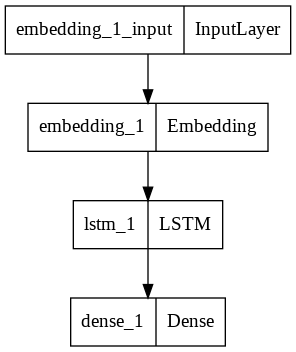

In [51]:
plot_model(model)

In [52]:
len(embed_input),y.shape

(20203, (20203,))

In [53]:
x_final = np.array(embed_input)
y_final = np.array(y)
x_final.shape, y_final.shape

((20203, 356), (20203,))

In [54]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.3, random_state=42)

<font color='#7ed6df'>fitting the model

In [56]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=64)

Epoch 1/10
221/221 [==============================] - 11s 26ms/step - loss: 0.3077 - accuracy: 0.8591 - val_loss: 0.1787 - val_accuracy: 0.9267
Epoch 2/10
221/221 [==============================] - 5s 24ms/step - loss: 0.1191 - accuracy: 0.9540 - val_loss: 0.1907 - val_accuracy: 0.9256
Epoch 3/10
221/221 [==============================] - 6s 26ms/step - loss: 0.0758 - accuracy: 0.9713 - val_loss: 0.2224 - val_accuracy: 0.9233
Epoch 4/10
221/221 [==============================] - 5s 24ms/step - loss: 0.0408 - accuracy: 0.9866 - val_loss: 0.2607 - val_accuracy: 0.9246
Epoch 5/10
221/221 [==============================] - 5s 24ms/step - loss: 0.0191 - accuracy: 0.9940 - val_loss: 0.3623 - val_accuracy: 0.9211
Epoch 6/10
221/221 [==============================] - 5s 24ms/step - loss: 0.0092 - accuracy: 0.9976 - val_loss: 0.3759 - val_accuracy: 0.9239
Epoch 7/10
221/221 [==============================] - 6s 26ms/step - loss: 0.1055 - accuracy: 0.9657 - val_loss: 0.3320 - val_accuracy: 0.916

<font color='#7ed6df'>Describe performance of classificaiton model <br>tweak to make sure that 'acc' and 'val_acc' and final 'accuracy' are more closer to each other. It is normal for validation accuracy to be lower than accuracy. But ideally, these values should be kept similar range. If validation accuracy is much lower than accuracy, be cautious of over fitting<br>acc' refers to accuracy of what was trained against. <br>'val_acc' refers to validation set. Note that val_acc refers to a set of samples that was not shown to the network during training and hence refers to how much your model works in general for cases outside the training set.

In [59]:
y_pred = model.predict(x_test)

In [62]:
#extract the predicted probabilities
y_pred = y_pred.flatten()
print(y_pred.round(2))

[1.   0.99 0.   ... 1.   1.   0.  ]


In [63]:
#extract the predicted class labels
y_pred = np.where(y_pred > 0.5, 1, 0) # transform; if > 0.5 then 1, else 0
print(y_pred)

[1 1 0 ... 1 1 0]


In [64]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9206401583897047

<font color='#7ed6df'>Evaluate Performance with Classification Report

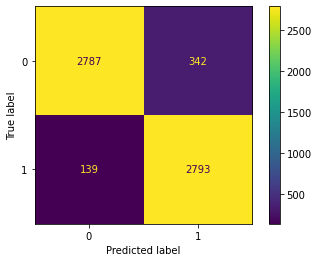

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [67]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      3129
           1       0.89      0.95      0.92      2932

    accuracy                           0.92      6061
   macro avg       0.92      0.92      0.92      6061
weighted avg       0.92      0.92      0.92      6061

